## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
print(train_data.text_list[0])

['discharg', 'summari', 'unsign', 'admiss', 'date', 'report', 'statu', 'unsign', 'discharg', 'date', 'discharg', 'diagnosi', 'coronari', 'arteri', 'diseas', 'unstabl', 'angina', 'histori', 'present', 'ill', 'hoopl', 'old', 'woman', 'statu', 'post', 'doubl', 'coronari', 'arteri', 'bypass', 'graft', 'endarterectomi', 'fourteen', 'year', 'ago', 'develop', 'angina', 'six', 'month', 'ago', 'suffer', 'unstabl', 'angina', 'sever', 'day', 'coronari', 'catheter', 'result', 'show', 'sever', 'occlus', 'saphen', 'vein', 'graft', 'occlus', 'left', 'anterior', 'descend', 'echocardiogram', 'show', 'excel', 'left', 'ventricular', 'function', 'intraaort', 'balloon', 'pump', 'place', 'reliev', 'intract', 'angina', 'past', 'medic', 'histori', 'signific', 'chest', 'pain', 'short', 'breath', 'admit', 'talc', 'commun', 'medic', 'center', 'catheter', 'coronari', 'arteri', 'bypass', 'graft', 'coronari', 'endarterectomi', 'no', 'chest', 'pain', 'six', 'month', 'prior', 'admiss', 'time', 'inder', 'aspirin', 'si

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(train_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0              remaind  0.904973
1   treatmentsprocedur  0.887019
2                 none  0.886652
3                brief  0.886613
4              uncompl  0.881954
5               commun  0.877383
6               detail  0.874349
7              univers  0.870438
8               memori  0.868962
9             procedur  0.850774
10                oper  0.849766
11                 yet  0.846652
12               refer  0.845161
13              hospit  0.844742
14               elect  0.843951
15              outsid  0.842797
16         colonoscopi  0.842689
17               taken  0.842130
18               evalu  0.839702
19             consult  0.838218


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0        hyperlipidemia  0.995819
1                factor  0.988974
2         gastroesophag  0.988495
3                anemia  0.988340
4                mother  0.985640
5        cardiomyopathi  0.984818
6                father  0.984576
7                 adult  0.981402
8        nephrolithiasi  0.981024
9                asthma  0.980728
10                 cabg  0.980687
11              depress  0.980548
12               reflux  0.980521
13          retinopathi  0.980521
14                 copd  0.980031
15               surgic  0.979810
16              syndrom  0.979259
17              endstag  0.979107
18               vessel  0.979099
19                 risk  0.978860


In [9]:
print(most_similar(model, ["angina"]))

            angina       cos
0          unstabl  0.989355
1           stroke  0.985264
2            bleed  0.985161
3        pneumonia  0.984367
4            chief  0.981603
5        complaint  0.978925
6   cardiomyopathi  0.978916
7          diagnos  0.977735
8           vessel  0.977668
9          problem  0.977409
10            copd  0.975794
11    appendectomi  0.975608
12         biliari  0.973268
13          cellul  0.973107
14         exacerb  0.972850
15          recent  0.972815
16          asthma  0.972651
17      transplant  0.972636
18           pacer  0.972283
19            cabg  0.970273


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "hypercholesterolemia"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  126.6799665158987


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  141.87399820417167


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  129.8430675917864


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  132.00812344789506


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  136.94106082603338


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  128.26151705384254


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  132.60128893993794


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

36.10739338636398

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.405
recall:  0.4550561797752809
F1-Score:  0.4285714285714286


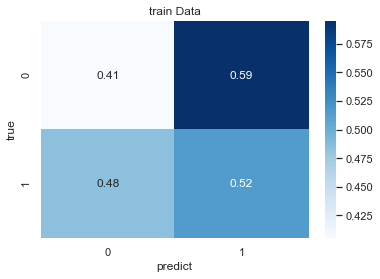

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.43
recall:  0.5
F1-Score:  0.4623655913978495


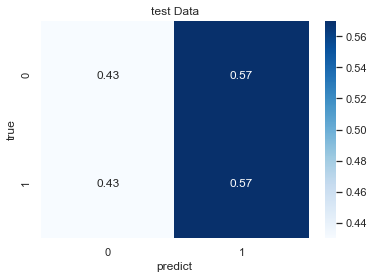

In [30]:
print_result(test_confusion_matrix, "test Data")